## Importation des librairies

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Définition des variables

### 1- Importation et nettoyage des fichiers

In [5]:
file_wb = 'C:/Users/bilel/OneDrive - CentraleSupelec/Stage EI/Version_V1/values.xlsx'
df_wb = pd.read_excel(file_wb)
file_ts = 'C:/Users/bilel/OneDrive - CentraleSupelec/Stage EI/Version_V1/value_transversal.xlsx'
df_ts = pd.read_excel(file_ts)


In [6]:
#traitement des variables à coef négatifs:
slice = df_wb['Valeurs'] < 0
df_wb.loc[slice, 'Variables'] = 'No_' + df_wb['Variables']
df_wb.loc[slice, 'Valeurs'] = df_wb['Valeurs'].abs()

### 2- Définition des variables globales

In [ ]:
delta = 0.015 #taux d'actualisation

Trans = -np.array([50 for i in range(14)]) #Etat des variables transversales considérées

horizon = 60 # Période de temps considérée

# Dictionnaire des delta_A: pour chacun des groupes, on a les variations correspondantes
dic_A_n_inf = {}
dic_A_n_inf[1] = [('Housing_quality', 0.6), ('No_Sleep_problems', 0.6), ('Physical_attractiveness', -0.4), ('Self-efficacy', 0.3), ('taille', 5000)]
dic_A_n_inf[2] = [('Housing_quality', 0.6), ('No_Sleep_problems', -0.3), ('Physical_attractiveness', -0.4), ('Self-efficacy', 0.3), ('taille', 2000)]
dic_A_n_inf[3] = [('Housing_quality', 0.4), ('No_Sleep_problems', 0.6), ('Physical_attractiveness', 0.7), ('Self-efficacy', -0.3), ('taille', 4000)]
dic_A_n_inf[4] = [('Housing_quality', 0.2), ('No_Sleep_problems', 0.6), ('Physical_attractiveness', -0.4), ('Self-efficacy', 0.3), ('taille', 1000)]

dic_A_n = [dic_A_n_inf for t in range(horizon)] #Listes de dictionnaires des delta_A pour chaque instant


nb_gp = len(list(dic_A_n_inf.keys())) #nombre de groupes

In [222]:
# Création d'un dictionnaire variable : beta_variable
df_to_dic = df_wb.set_index('Variables')
dic_wb = df_to_dic['Valeurs'].to_dict()

## Définiton des modèles transversaux

### 1- Définition du modèle de kt

In [8]:
# Fonction de régression de k_t
def K_t(X):
    df = df_ts.copy()
    df['input'] = X
    return sum(df['input']*df['Coef reg kt non normalisé'])

In [9]:
w_t = K_t(np.array([100 for i in range(14)])) # worst case

In [10]:
#Modèle logarithmique, faible concavité
def kt_1(X):
    arg_1 = (np.exp(1)-1)/w_t
    arg_2 = np.exp(1)
    return np.log(arg_1*K_t(X)+arg_2)


In [11]:
#Modèle exponentielle décroissante, concavité plus forte
def kt_2(X):
    arg = -3*(K_t(X)+w_t)/(w_t)
    return 1 - np.exp(arg)


### 2- Définiton du modèle de p_s:

In [87]:
alpha_ps = 0.004 #paramètre pour régler la référence sur p_s

In [88]:
# Fonction de régression de p_s

def K_s(X):
    df = df_ts.copy()
    df['input'] = X
    return alpha_ps*sum(df['input']*df['Coef reg ps non normalisé'])

In [14]:
w_s = K_s(np.array([100 for i in range(14)])) # worst case

In [92]:
#Regression logistique asymétrique

def p_s(X, beta=0.05):
    arg = np.exp(-K_s(X))
    return 1/(1+beta*arg)

## Calcul de l'impact

In [215]:
def calcul_impact(dic_A_n, Trans, horizon):
    I = 0
    k = kt_2(Trans)
    p = p_s(Trans)
    dic_I = {}
    for t in range(horizon):
        fac = (1/(1+delta))**(t/12)                 #facteur d'actualisation
        wb = 0
        n_tot = 0                                      #wb à l'instant t sommé sur tous les couples (groupe, variable)
        for gp, X in dic_A_n[t].items():
            wb_gp = 0
            n = X[-1][1]
            for var_val in X[:-1]:
                var = var_val[0]
                A = var_val[1]
                if A > 0:                               #Delta positifs ou négatifs
                    X = k * p * A  
                else:
                    X = (2 - k) * p * A
                wb_var = dic_wb[var] * X
                wb_gp += wb_var
            n_tot += n
            dic_I[(gp,t)] = (wb_gp*fac, n_tot)
            wb += wb_gp*n
        wb_somme_temp = fac * wb
        I += wb_somme_temp
    return I, dic_I

In [216]:
def plus_proche_valeur(n,L):
    ind = 0
    if n>L[-1][1]:
        return len(L),0
    while n>L[ind][1]:
        ind+=1
    return ind, L[ind][0]

In [217]:
def fonction_impact_inf(dic_A_n, Trans, horizon, n, t):
    dic_I = calcul_impact(dic_A_n, Trans, horizon)[1]
    sub_dic = {groupe: valeur for (groupe, temps), valeur in dic_I.items() if temps == t}
    L = list(sub_dic.values())
    return plus_proche_valeur(n,L)[1]
    

0.0006062972419572584

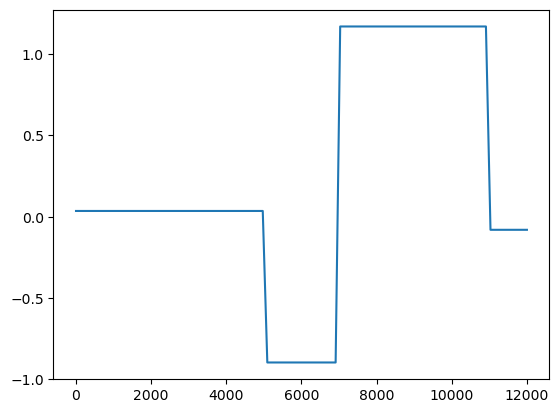

In [218]:
def fonction_impact_gp(n):
    T = np.linspace(0,horizon -1,horizon, dtype=int)
    return sum([fonction_impact_inf(dic_A_n, Trans, horizon, n, t) for t in T])


imp_gp_vect = np.vectorize(fonction_impact_gp)
n = np.linspace(0, 12000, 100)
I = imp_gp_vect(n)
plt.plot(n,I)
plt.show()

In [219]:
dic_I = calcul_impact(dic_A_n, Trans, horizon)[1]
sub_dic = {groupe: valeur for (groupe, temps), valeur in dic_I.items() if temps == 2}
fonction_impact(dic_A_n, Trans, horizon, 6000, 2)

def imp(n,t):
    return fonction_impact_inf(dic_A_n, Trans, horizon, n, t)
imp_vectorized = np.vectorize(imp)
n = np.linspace(0, 12000, 100)
t = np.linspace(0,horizon -1,horizon, dtype=int)
N, T = np.meshgrid(n, t)
I = imp_vectorized(N,T)

#I = [fonction_impact(dic_A_n, Trans, horizon, x, y) for (x,y) in zip(N,T) ]

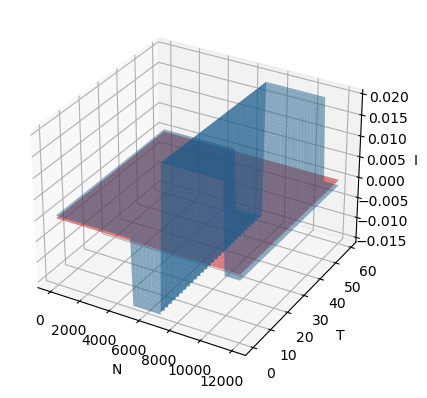

In [220]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(N, T, I, alpha = 0.5, label='distribution du well-being')
ax.plot_surface(N, T, np.zeros_like(I), alpha=0.5, color='red', label='I=0')
# Ajouter des étiquettes aux axes
ax.set_xlabel('N')
ax.set_ylabel('T')
ax.set_zlabel('I')
# Afficher le plot
plt.show()

## Calcul des ressources

In [ ]:
def dynamique_CO2(delta_A):

In [ ]:
#On suppose que les coûts ont déjà été sommés sur la période étudiée
def calcul_impact_ressources(A_s, A_e, Trans):
    beta = np.array([dic_wb['Assessment_financial_situation'], dic_wb['Climatic']])
    ps = p_s(Trans)
    kt = kt_1(Trans)
    wb_s = sum(beta*A_s)
    wb_e = sum(beta*A_e)
    return (2-kt)*(ps*wb_s+(1-ps*wb_e))